In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
%matplotlib inline

In [2]:
factors = pd.read_csv('holt_factor_data.csv',sep='|',encoding='utf-8',thousands=',')
factors.head()

,company_ref_no,gic_sector_nm,gic_subindustry_id,country_cd,region_id,datadate,fx_rate,mcap_local,mcap_usd,ev_lfy,...,asset_growth_fy1,roic_lfy,roic_fy1,roic_fy2,coverage_fy1,prc_return_1m,prc_return_12m,tsr_fwd1,tsr_fwd3,tsr_fwd12
0,5049,Information Technology,45301020,USA,100108,19991031,1.0,1.40335,1.40335,NaN,...,103.54059,1.30212,-7.63576,1.04161,0.36582,15.24752,83.01886,5.67,52.58,217.27
1,5049,Information Technology,45301020,USA,100108,20000131,1.0,2.14119,2.14119,NaN,...,103.54059,1.30212,-4.32059,3.39081,0.48270,70.44145,179.24529,104.05,156.76,-3.21
2,5049,Information Technology,45301020,USA,100108,20000430,1.0,6.02984,6.02984,1226.7323,...,226.32947,7.52600,6.24398,6.15711,1.00114,-6.80564,616.98114,-6.97,18.88,-76.84
3,5049,Information Technology,45301020,USA,100108,20000731,1.0,7.80929,7.80929,1226.7323,...,622.28265,7.52600,6.79984,5.68753,1.05230,-7.48752,567.61090,6.64,-31.88,-85.83
4,5049,Information Technology,45301020,USA,100108,20001031,1.0,5.51134,5.51134,1226.7323,...,664.74760,7.52600,9.31426,7.84159,1.13359,-36.93647,217.26804,-59.30,-53.45,-84.45


In [3]:
factors.columns

Index(['company_ref_no', 'gic_sector_nm', 'gic_subindustry_id', 'country_cd',
       'region_id', 'datadate', 'fx_rate', 'mcap_local', 'mcap_usd', 'ev_lfy',
       'eps_lfy', 'eps_fy1', 'eps_fy2', 'ebitda_lfy', 'ebitda_fy1',
       'ev_ebitda_lfy', 'ev_ebitda_fy1', 'div_yeild', 'sales_lfy', 'sales_fy1',
       'sales_fy2', 'sales_growth_lfy', 'asset_growth_lfy', 'asset_growth_fy1',
       'roic_lfy', 'roic_fy1', 'roic_fy2', 'coverage_fy1', 'prc_return_1m',
       'prc_return_12m', 'tsr_fwd1', 'tsr_fwd3', 'tsr_fwd12'],
      dtype='object')

In [4]:
factors.prc_return_12m.describe()

count    3.989170e+05
mean     1.196985e+02
std      8.614651e+03
min     -9.999190e+01
25%     -9.145430e+00
50%      1.073209e+01
75%      3.577982e+01
max      2.316972e+06
Name: prc_return_12m, dtype: float64

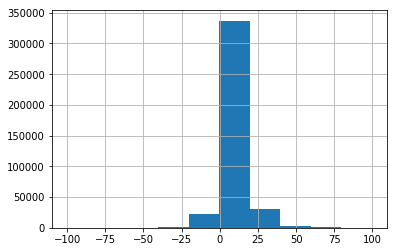

In [5]:
factors[abs(factors.roic_lfy)<100].roic_lfy.hist()

In [6]:
factors.roic_lfy.describe()

count    398331.000000
mean          9.304730
std          19.346657
min       -2440.352300
25%           4.090630
50%           7.868990
75%          12.837295
max        3466.624500
Name: roic_lfy, dtype: float64

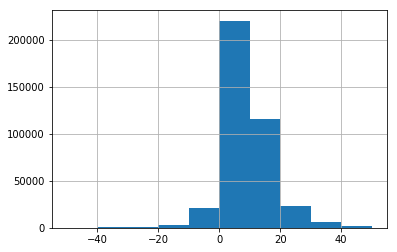

In [7]:
factors[abs(factors.roic_lfy)<50].roic_lfy.hist()

In [8]:
#Melt
index_cols = ['company_ref_no', 'gic_sector_nm', 'gic_subindustry_id', 'country_cd', 'region_id', 'datadate', 'fx_rate','tsr_fwd1', 'tsr_fwd3', 'tsr_fwd12']

#value_vars = ['price', 'ev_lfy', 'ev_fy1', 'eps_lfy', 'eps_fy1', 'eps_fy2', 'ebitda_lfy', 'ebitda_fy1', 'ev_ebitda_lfy',
# 'ev_ebitda_fy1', 'div_yeild', 'pe_lfy', 'pe_fy1', 'sales_lfy', 'sales_fy1', 'sales_fy2', 'sales_growth_lfy', 'assets',
# 'assets_fy1', 'asset_growth_lfy', 'asset_growth_fy1', 'roic_lfy', 'roic_fy1', 'roic_fy2', 'coverage_fy1', 'prc_return_1m',
# 'prc_return_12m']

#value_vars = ['eps_lfy','eps_fy1','eps_fy2','ev_ebitda_lfy','ev_ebitda_fy1','div_yeild','pe_lfy','pe_fy1',
#              'sales_lfy','sales_growth_lfy','roic_lfy','coverage_fy1','prc_return_1m','prc_return_12m']

#value_vars = ['eps_fy1','ev_ebitda_fy1','div_yeild','pe_fy1','sales_growth_lfy','roic_lfy','coverage_fy1','prc_return_12m']

value_vars = ['ev_ebitda_fy1','prc_return_12m']
factors_deep = pd.melt(factors, id_vars= index_cols, value_vars = value_vars)
print(len(factors_deep))
factors_deep.dropna(inplace=True)
print(len(factors_deep))

797944
779232


In [9]:
# Add z-scores
z_score = lambda x: (x - x.mean()) / x.std()
group = ['datadate','variable']
sector_grouping = ['gic_sector_nm','region_id','datadate','variable']


factors_deep['value_median'] = factors_deep.groupby(sector_grouping)['value'].transform(np.median)
factors_deep['zscore'] = factors_deep.groupby(group)['value'].transform(z_score)
factors_deep['sector_region_zscore'] = factors_deep.groupby(sector_grouping)['value'].transform(z_score)

factors_deep['value_adj'] = np.where(abs(factors_deep['zscore'])>4,factors_deep['value_median'],factors_deep['value'])
factors_deep['zscore'] = factors_deep.groupby(sector_grouping)['value_adj'].transform(z_score)

factors_deep['value_adj'] = np.where(abs(factors_deep['sector_region_zscore'])>4,factors_deep['value_median'],factors_deep['value'])
factors_deep['sector_region_zscore'] = factors_deep.groupby(sector_grouping)['value_adj'].transform(z_score)



In [10]:
#Convert the yields
convert_to_yield = ['ev_ebitda_lfy','ev_ebitda_fy1','ev_ebitda_fy2','pe_lfy','pe_fy1','pe_fy2']
for i in convert_to_yield:
    factors_deep['zscore'] = np.where(factors_deep['variable']==i,-1*factors_deep['zscore'],factors_deep['zscore'])
    factors_deep['sector_region_zscore'] = np.where(factors_deep['variable']==i,-1*factors_deep['sector_region_zscore'],factors_deep['sector_region_zscore'])
    

In [11]:
# Convert z-scores and add Quintiles
factors_deep['score'] = factors_deep['zscore'].apply(lambda x: norm.cdf(x))
factors_deep['sector_region_score'] = factors_deep['sector_region_zscore'].apply(lambda x: norm.cdf(x))

factors_deep['score_quintile'] = factors_deep.groupby(group)['score'].apply(lambda x: pd.qcut(x,q=5,labels=[1,2,3,4,5]))
factors_deep['sector_region_score_quintile'] = factors_deep.groupby(group)['score'].apply(lambda x: pd.qcut(x,q=5,labels=[1,2,3,4,5]))


In [12]:
score_median = factors_deep.groupby(['variable','score_quintile'])['tsr_fwd1', 'tsr_fwd3', 'tsr_fwd12'].apply(np.median)
score_average = factors_deep.groupby(['variable','score_quintile'])['tsr_fwd1', 'tsr_fwd3', 'tsr_fwd12'].apply(np.mean)
sector_region_score_median = factors_deep.groupby(['variable','sector_region_score_quintile'])['tsr_fwd1', 'tsr_fwd3', 'tsr_fwd12'].apply(np.median)
sector_region_score_average = factors_deep.groupby(['variable','sector_region_score_quintile'])['tsr_fwd1', 'tsr_fwd3', 'tsr_fwd12'].apply(np.mean)

In [16]:
sector_region_score_average

tsr_fwd1  tsr_fwd3  tsr_fwd12
variable       sector_region_score_quintile                               
ev_ebitda_fy1  1                             0.573480  2.244628   8.614803
               2                             0.620839  2.543597  11.142382
               3                             0.738261  2.471585   9.864745
               4                             0.727842  2.497262  10.101300
               5                             0.681143  2.953083  12.373434
prc_return_12m 1                             0.628711  1.641018   9.206789
               2                             0.643476  2.345417   9.937579
               3                             0.659418  2.812747  10.767394
               4                             0.695187  2.708331  10.632621
               5                             0.702355  3.179232  11.435725